%%latex
\tableofcontents 
\setcounter{section}{0}

# Bibliography section

%%latex
\bibliographystyle{alphadin}
\bibliography{ipython}

In [129]:
from part2 import *

def create_grain_from_data(dF):
    if type(dF)==pd.Series:
        dF = pd.DataFrame([dF])
        
    if len(dF['temp'].unique())==1:
        T_C = dF['temp'].unique()[0]
    else:
        raise Exception('Multiple paramters for one grain are invalid.')
    
    if len(dF['ND'].unique())==1:
        ND = dF['ND'].unique()[0]
    else:
        raise Exception('Multiple paramters for one grain are invalid.')
    
    if len(dF['mass_eff'].unique())==1:
        mass_e_eff_factor = dF['mass_eff'].unique()[0]/CONST.MASS_E 
    else:
        raise Exception('Multiple paramters for one grain are invalid.')
    
    if len(dF['R'].unique())==1:
        grainsize_radius = dF['R'].unique()[0]
    else:
        raise Exception('Multiple paramters for one grain are invalid.')
        

    

    material = Material(T_C,ND)
    grain = Grain(grainsize_radius=grainsize_radius,material=material)
    
    return grain


## Data from the publication

![test](media/rawdata450_1000.jpg)

# Import the experimental results

In [130]:
calc_dF = pd.read_hdf('numerical_sol_2.h5','raw')

dF_450 = pd.read_excel('Kelvin_Data.xlsx', sheet_name='ipc450').sort_values(by='dV')
dF_1000 = pd.read_excel('Kelvin_Data.xlsx', sheet_name='ipc1000').sort_values(by='dV')

gs = calc_dF.groupby(['R','ND'])

In [131]:
%pylab qt5
%matplotlib qt5

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['interp', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [132]:
from scipy.optimize import curve_fit



(10, 1000000000.0)

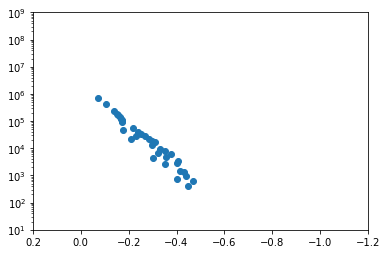

In [133]:
fig, axe = subplots()
axe.scatter(dF_450['dV'],dF_450['res'])
axe.set_yscale('log')
axe.set_xlim(0.2,-1.2)
axe.set_ylim(10,1e9)

In [134]:
sizes = {'IPC 1000':[100e-9, 50e-9], 'IPC 450':[6.25e-9, 12.5e-9]}
sizes = {'IPC 1000':[50e-9], 'IPC 450':[6.25e-9]}

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['interp', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


(5e-08, 1e+22)         5.093919
(5e-08, 1e+21)        12.950139
(5e-08, 1e+23)       322.816574
(5e-08, 1e+24)    504637.193166
dtype: float64

(6.25e-09, 1e+21)       10.118508
(6.25e-09, 1e+22)       18.067190
(6.25e-09, 1e+23)      732.871140
(6.25e-09, 1e+24)    29427.948572
dtype: float64

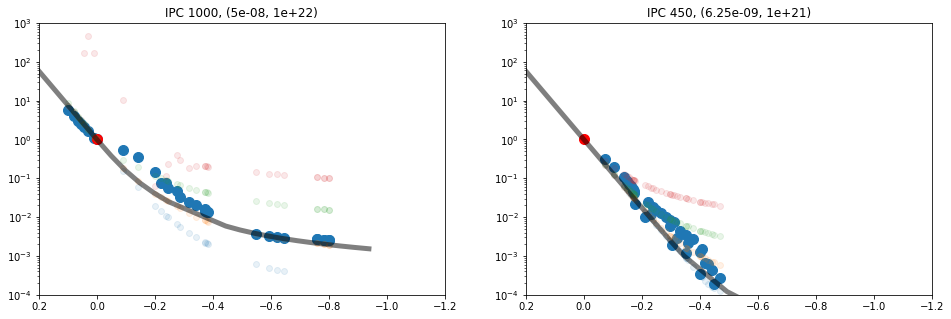

In [136]:
%pylab inline
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pandas as pd


def fit_func(x, a, b, c,d,e):
    return a * np.exp(b* x**2+c* x+d + e*x**3)

rescaled = True

fig, axes = subplots(1,2, figsize=(16,5))
for ax_i, (sens, dF) in enumerate([('IPC 1000',dF_1000),('IPC 450',dF_450)]):
    axe = fig.axes[ax_i]
    axe.set_title(sens)
    
    
    around_0_indx = dF['dV'].abs().sort_values().index[0:5]
    x_fit = dF.loc[around_0_indx, 'dV']
    y_fit = dF.loc[around_0_indx, 'res']
        
    def fit_func(x, a, b):
        return a * np.exp(-b * x)

    g_fit_params,_ = curve_fit(fit_func, x_fit, y_fit, sigma=1/y_fit)

    res_flatband = fit_func(0, *g_fit_params)
    
    
    if rescaled:
        y = dF['res']/res_flatband
        axe.set_ylim((1e-4,1e3))
    else:
        y = dF['res']
        axe.set_ylim((10,10e6))
        
    axe.scatter(dF['dV'],y, s=100)
    
    if rescaled:
        axe.scatter(0, 1, s=100, label = 'Resistance Nitrogen', c='r')
    else:
        axe.scatter(0, res_flatband, s=100, label = 'Resistance Nitrogen', c='r')
    
    axe.set_xlim((0.2,-1.2))
    axe.set_yscale('log')
    
    diff_dF = pd.DataFrame(index = dF['dV'])
    
    calc_dF_sizes = calc_dF.copy()
    calc_dF_sizes = calc_dF_sizes[calc_dF_sizes['R'].isin(sizes[sens])]
    gs = calc_dF_sizes.groupby(['R','ND'])
    
    if rescaled:
        for (R,ND), calc_dF_grainsize in gs:
            #diff_dF[f'{R}_{ND}'] = None
            diff_dF[(R,ND)] = None
            grain = create_grain_from_data(calc_dF_grainsize)
            flat_band = calc_dF_grainsize[calc_dF_grainsize['Einit_kT']==0].iloc[0]['current']
            
            res = flat_band/calc_dF_grainsize['current']
            v = calc_dF_grainsize['Einit_kT']*CONST.J_to_eV(grain.material.kT)
            #axe.plot(v,res, 'o', alpha=0.1)

            interp = interp1d(v, res, kind='cubic', bounds_error=False)
            y_from_num = interp(dF['dV'])
            
            axe.plot(dF['dV'],y_from_num, 'o', alpha=0.1)
            
            
            diff_dF.loc[:,(R,ND)] = ((y_from_num-y.values)/y.values)**2
    
        m = diff_dF.abs().sum().idxmin()
    
    
        for (R,ND), calc_dF_grainsize in gs:
            if (R,ND)==diff_dF.abs().sum().sort_values().index[0]:
                linestyle= 'k-'
            elif (R,ND)==diff_dF.abs().sum().sort_values().index[1]:
                linestyle= 'r--'
                continue
            else:
                continue
            
            grain = create_grain_from_data(calc_dF_grainsize)
            flat_band = calc_dF_grainsize[calc_dF_grainsize['Einit_kT']==0].iloc[0]['current']
            
            res = flat_band/calc_dF_grainsize['current']
            v = calc_dF_grainsize['Einit_kT']*CONST.J_to_eV(grain.material.kT)
            #axe.plot(v,res, 'o', alpha=0.1)

            interp = interp1d(v, res, kind='cubic', bounds_error=False)
            y_from_num = interp(dF['dV'])
            
            #axe.plot(dF['dV'],y_from_num, 'o', alpha=0.1)
            axe.plot(v,res, linestyle, linewidth=5,alpha=0.5)
            
            
            #diff_dF.loc[:,(R,ND)] = ((y_from_num-y.values)/y.values)**2
    
        display(diff_dF.abs().sum().sort_values())
    
    axe.set_title(f'{sens}, {m}')
    

            
            
        
       
    

    


![test](media/WF450und1000.jpg)